# Menyiapkan library yang dibutuhkan

In [ ]:
# Hapus versi ONNX yang tidak kompatibel
!pip uninstall -y onnx

# Install versi yang kompatibel
!pip install onnx==1.15.0 onnxmltools

Found existing installation: onnx 1.15.0
Uninstalling onnx-1.15.0:
  Successfully uninstalled onnx-1.15.0
  Using cached onnx-1.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
Using cached onnx-1.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.7 MB)


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from google.colab import files
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data yang sudah dibersihkan sebelumnya

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/laskar ai/capstone/data_preprocessed.csv'
df_kek = pd.read_csv(file_path)
df_kek.T

,0,1,2,3,4,5,6,7,8,9,...,12320,12321,12322,12323,12324,12325,12326,12327,12328,12329
Umur Ibu (tahun),34.0,28.0,28.0,28.0,29.0,29.0,33.0,41.0,33.0,27.0,...,25.0,18.0,42.0,30.0,28.0,35.0,23.0,30.0,24.0,29.0
Jenis Asuransi,BPJS,BPJS,BPJS,BPJS,Tidak Mempunyai Asuransi,BPJS,Tidak Mempunyai Asuransi,Tidak Mempunyai Asuransi,BPJS,BPJS,...,BPJS,BPJS,BPJS,BPJS,BPJS,BPJS,BPJS,BPJS,Tidak Mempunyai Asuransi,BPJS
HPHT,2023-11-28,2023-12-05,2023-12-08,2023-12-01,2024-02-19,2024-01-25,2024-01-03,2023-11-27,2024-02-15,2024-02-08,...,2023-12-02,2023-12-05,2023-09-24,2023-05-05,2023-06-15,2023-09-25,2023-05-22,2023-10-04,2023-11-07,2023-07-01
HPL,2024-09-04,2024-09-12,2024-09-15,2024-09-08,2024-11-26,2024-11-02,2024-10-10,2024-09-03,2024-11-22,2024-11-15,...,2024-09-09,2024-09-12,2024-07-01,2024-02-12,2024-03-22,2024-07-02,2024-02-29,2024-07-11,2024-08-14,2024-04-06
TB (cm),158.0,150.0,155.0,150.0,155.0,150.0,162.0,150.0,150.0,155.0,...,153.0,153.0,157.0,156.0,155.0,152.0,160.0,165.0,156.0,155.0
IMT Sebelum Hamil,Normal,Normal,Normal,Kurus,Gemuk/Obesitas,Normal,Kurus,Normal,Gemuk/Obesitas,Gemuk/Obesitas,...,Normal,Kurus,Gemuk/Obesitas,Gemuk/Obesitas,Normal,Normal,Normal,Normal,Normal,Normal
Jarak Hamil,4.0,4.0,4.0,4.0,14.0,5.0,6.0,4.0,6.0,6.0,...,3.0,2.0,8.0,8.0,9.0,18.0,3.0,4.0,3.0,5.0
Status Td,T2,T2,T2,T1,T2,T2,T2,T2,T2,T1,...,T2,T1,T2,T2,T2,T2,T1,T3,T2,T2
Status Gizi,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,...,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal,Normal
Tinggi Fundus Uteri (TFU),32.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,...,25.0,27.0,27.0,27.0,27.0,27.0,27.0,31.0,27.0,27.0


# preprocessing

In [ ]:
# Buat fitur baru
df_kek['HPHT'] = pd.to_datetime(df_kek['HPHT'])
df_kek['HPL'] = pd.to_datetime(df_kek['HPL'])
df_kek['Usia Kehamilan Minggu'] = ((df_kek['HPL'] - df_kek['HPHT']).dt.days // 7)
df_kek.drop(columns=['HPHT', 'HPL'], inplace=True)

In [ ]:
# Ganti NaN jadi 'Tidak diketahui' di kolom kategorikal tertentu
kategori_kolom = [
    'Tempat Bersalin', 'Penolong Persalinan', 'Rujuk Ibu Nifas',
    'Kondisi Ibu', 'Kondisi Bayi', 'Konseling'
]
df_kek[kategori_kolom] = df_kek[kategori_kolom].fillna('Tidak diketahui')

In [ ]:
# Target
target = 'Status Gizi'
X = df_kek.drop(columns=[target])
y = df_kek[target]

# Mapping target
target_mapping = {'KEK': 0, 'Normal': 1, 'Resiko KEK': 2}
y = y.map(target_mapping)

In [ ]:
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Imputer
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_imputer, numerical_cols),
    ('cat', Pipeline([('imputer', cat_imputer), ('encoder', encoder)]), categorical_cols)
])

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Modelling

## random Forest

=== Random Forest ===
Akurasi      : 0.9590
Precision    : 0.9539
Recall       : 0.9590
F1 Score     : 0.9504
Waktu Latih  : 15.60 detik

Classification Report:
               precision    recall  f1-score   support

         KEK       0.78      0.47      0.58       111
      Normal       0.96      1.00      0.98      2316
  Resiko KEK       0.83      0.13      0.22        39

    accuracy                           0.96      2466
   macro avg       0.86      0.53      0.60      2466
weighted avg       0.95      0.96      0.95      2466



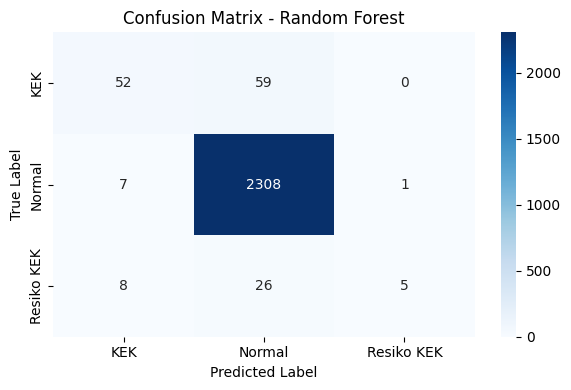

In [ ]:
# Pipeline khusus Random Forest
rf_pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Training dengan waktu
start_time_rf = time.time()
rf_pipeline.fit(X_train, y_train)
training_time_rf = time.time() - start_time_rf

# Prediksi
y_pred_rf = rf_pipeline.predict(X_test)

# Evaluasi metrik
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print("=== Random Forest ===")
print(f"Akurasi      : {accuracy_rf:.4f}")
print(f"Precision    : {precision_rf:.4f}")
print(f"Recall       : {recall_rf:.4f}")
print(f"F1 Score     : {f1_rf:.4f}")
print(f"Waktu Latih  : {training_time_rf:.2f} detik")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=target_mapping.keys()))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
labels = list(target_mapping.keys())

# Visualisasi confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Gradient Boosting

=== Gradient Boosting ===
Akurasi      : 0.9692
Precision    : 0.9721
Recall       : 0.9692
F1 Score     : 0.9704
Waktu Latih  : 370.19 detik

Classification Report:
               precision    recall  f1-score   support

         KEK       0.77      0.79      0.78       111
      Normal       0.99      0.98      0.99      2316
  Resiko KEK       0.50      0.67      0.57        39

    accuracy                           0.97      2466
   macro avg       0.75      0.81      0.78      2466
weighted avg       0.97      0.97      0.97      2466



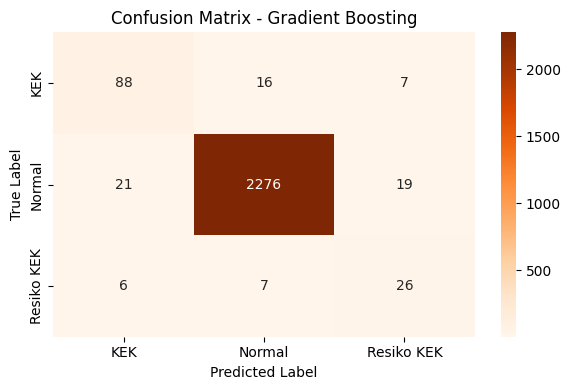

In [ ]:
# Pipeline Gradient Boosting
gb_pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Waktu training
start_time_gb = time.time()
gb_pipeline.fit(X_train, y_train)
training_time_gb = time.time() - start_time_gb

# Prediksi
y_pred_gb = gb_pipeline.predict(X_test)

# Evaluasi
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='weighted')
recall_gb = recall_score(y_test, y_pred_gb, average='weighted')
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

print("=== Gradient Boosting ===")
print(f"Akurasi      : {accuracy_gb:.4f}")
print(f"Precision    : {precision_gb:.4f}")
print(f"Recall       : {recall_gb:.4f}")
print(f"F1 Score     : {f1_gb:.4f}")
print(f"Waktu Latih  : {training_time_gb:.2f} detik")
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb, target_names=target_mapping.keys()))

# Confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
labels = list(target_mapping.keys())

# Visualisasi
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## XGBoost

=== XGBoost ===
Akurasi      : 0.9769
Precision    : 0.9754
Recall       : 0.9769
F1 Score     : 0.9759
Waktu Latih  : 37.88 detik

Classification Report:
               precision    recall  f1-score   support

         KEK       0.83      0.77      0.79       111
      Normal       0.99      0.99      0.99      2316
  Resiko KEK       0.73      0.56      0.64        39

    accuracy                           0.98      2466
   macro avg       0.85      0.77      0.81      2466
weighted avg       0.98      0.98      0.98      2466



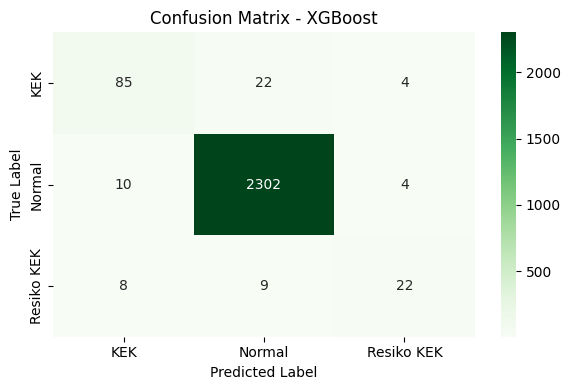

In [ ]:
# Pipeline XGBoost
xgb_pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# Training
start_time_xgb = time.time()
xgb_pipeline.fit(X_train, y_train)
training_time_xgb = time.time() - start_time_xgb

# Prediksi
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluasi
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print("=== XGBoost ===")
print(f"Akurasi      : {accuracy_xgb:.4f}")
print(f"Precision    : {precision_xgb:.4f}")
print(f"Recall       : {recall_xgb:.4f}")
print(f"F1 Score     : {f1_xgb:.4f}")
print(f"Waktu Latih  : {training_time_xgb:.2f} detik")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=target_mapping.keys()))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## LightGBM

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50276
[LightGBM] [Info] Number of data points in the train set: 27795, number of used features: 696
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


=== LightGBM ===
Akurasi      : 0.9765
Precision    : 0.9749
Recall       : 0.9765
F1 Score     : 0.9753
Waktu Latih  : 12.92 detik

Classification Report:
               precision    recall  f1-score   support

         KEK       0.83      0.77      0.80       111
      Normal       0.99      0.99      0.99      2316
  Resiko KEK       0.78      0.54      0.64        39

    accuracy                           0.98      2466
   macro avg       0.87      0.77      0.81      2466
weighted avg       0.97      0.98      0.98      2466



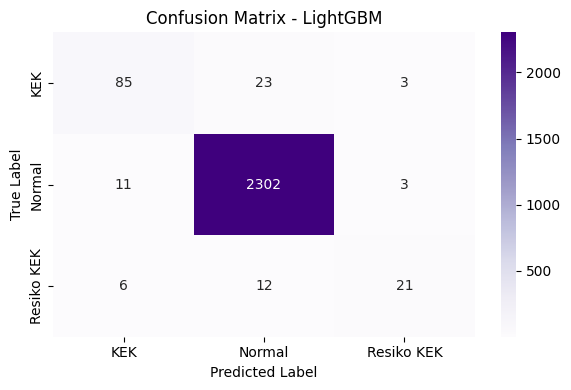

In [ ]:
# Pipeline LightGBM
lgbm_pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(random_state=42))
])

# Training
start_time_lgbm = time.time()
lgbm_pipeline.fit(X_train, y_train)
training_time_lgbm = time.time() - start_time_lgbm

# Prediksi
y_pred_lgbm = lgbm_pipeline.predict(X_test)

# Evaluasi
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm, average='weighted')
recall_lgbm = recall_score(y_test, y_pred_lgbm, average='weighted')
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='weighted')

print("=== LightGBM ===")
print(f"Akurasi      : {accuracy_lgbm:.4f}")
print(f"Precision    : {precision_lgbm:.4f}")
print(f"Recall       : {recall_lgbm:.4f}")
print(f"F1 Score     : {f1_lgbm:.4f}")
print(f"Waktu Latih  : {training_time_lgbm:.2f} detik")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm, target_names=target_mapping.keys()))

# Confusion Matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - LightGBM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## AdaBoost

=== AdaBoost ===
Akurasi      : 0.9197
Precision    : 0.9593
Recall       : 0.9197
F1 Score     : 0.9355
Waktu Latih  : 26.83 detik

Classification Report:
               precision    recall  f1-score   support

         KEK       0.55      0.74      0.63       111
      Normal       0.99      0.93      0.96      2316
  Resiko KEK       0.21      0.77      0.33        39

    accuracy                           0.92      2466
   macro avg       0.58      0.81      0.64      2466
weighted avg       0.96      0.92      0.94      2466



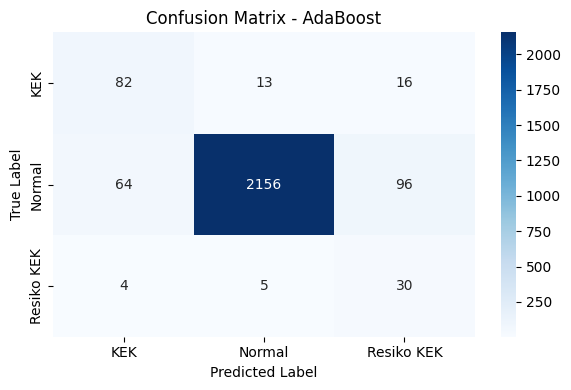

In [ ]:
# Pipeline AdaBoost
ada_pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', AdaBoostClassifier(random_state=42))
])

# Training
start_time_ada = time.time()
ada_pipeline.fit(X_train, y_train)
training_time_ada = time.time() - start_time_ada

# Prediksi
y_pred_ada = ada_pipeline.predict(X_test)

# Evaluasi
accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada, average='weighted')
recall_ada = recall_score(y_test, y_pred_ada, average='weighted')
f1_ada = f1_score(y_test, y_pred_ada, average='weighted')

print("=== AdaBoost ===")
print(f"Akurasi      : {accuracy_ada:.4f}")
print(f"Precision    : {precision_ada:.4f}")
print(f"Recall       : {recall_ada:.4f}")
print(f"F1 Score     : {f1_ada:.4f}")
print(f"Waktu Latih  : {training_time_ada:.2f} detik")
print("\nClassification Report:\n", classification_report(y_test, y_pred_ada, target_names=target_mapping.keys()))

# Confusion Matrix
cm_ada = confusion_matrix(y_test, y_pred_ada)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - AdaBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Extra Trees

=== Extra Trees ===
Akurasi      : 0.9485
Precision    : 0.9340
Recall       : 0.9485
F1 Score     : 0.9400
Waktu Latih  : 370.19 detik

Classification Report:
               precision    recall  f1-score   support

         KEK       0.57      0.45      0.51       111
      Normal       0.96      0.99      0.98      2316
  Resiko KEK       0.17      0.03      0.04        39

    accuracy                           0.95      2466
   macro avg       0.57      0.49      0.51      2466
weighted avg       0.93      0.95      0.94      2466



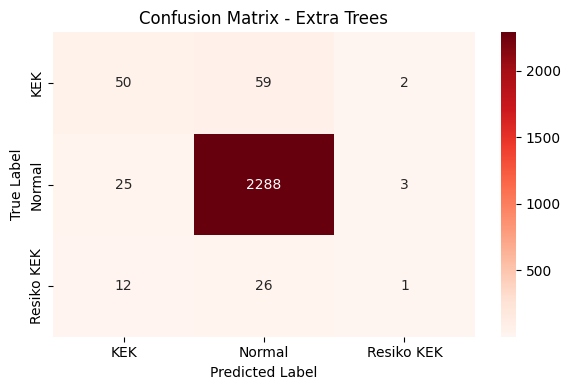

In [ ]:
# Pipeline Extra Trees
et_pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', ExtraTreesClassifier(random_state=42))
])

# Training
start_time_et = time.time()
et_pipeline.fit(X_train, y_train)
training_time_et = time.time() - start_time_et

# Prediksi
y_pred_et = et_pipeline.predict(X_test)

# Evaluasi
accuracy_et = accuracy_score(y_test, y_pred_et)
precision_et = precision_score(y_test, y_pred_et, average='weighted')
recall_et = recall_score(y_test, y_pred_et, average='weighted')
f1_et = f1_score(y_test, y_pred_et, average='weighted')

print("=== Extra Trees ===")
print(f"Akurasi      : {accuracy_et:.4f}")
print(f"Precision    : {precision_et:.4f}")
print(f"Recall       : {recall_et:.4f}")
print(f"F1 Score     : {f1_et:.4f}")
print(f"Waktu Latih  : {training_time_et:.2f} detik")
print("\nClassification Report:\n", classification_report(y_test, y_pred_et, target_names=target_mapping.keys()))

# Confusion Matrix
cm_et = confusion_matrix(y_test, y_pred_et)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_et, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Extra Trees')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Decision Tree

=== Decision Tree ===
Akurasi      : 0.9481
Precision    : 0.9537
Recall       : 0.9481
F1 Score     : 0.9507
Waktu Latih  : 6.08 detik

Classification Report:
               precision    recall  f1-score   support

         KEK       0.61      0.68      0.64       111
      Normal       0.98      0.97      0.98      2316
  Resiko KEK       0.27      0.36      0.31        39

    accuracy                           0.95      2466
   macro avg       0.62      0.67      0.64      2466
weighted avg       0.95      0.95      0.95      2466



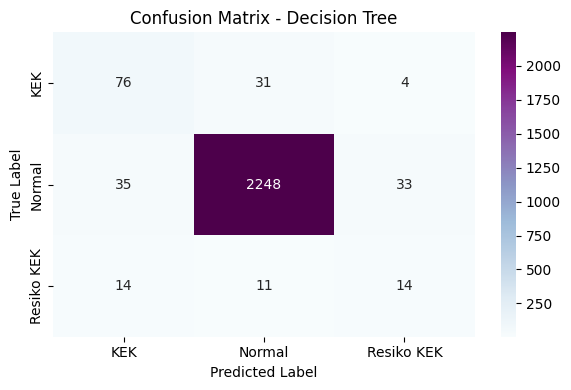

In [ ]:
# Pipeline Decision Tree
dt_pipeline = ImbPipeline(steps=[
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Training
start_time_dt = time.time()
dt_pipeline.fit(X_train, y_train)
training_time_dt = time.time() - start_time_dt

# Prediksi
y_pred_dt = dt_pipeline.predict(X_test)

# Evaluasi
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')

print("=== Decision Tree ===")
print(f"Akurasi      : {accuracy_dt:.4f}")
print(f"Precision    : {precision_dt:.4f}")
print(f"Recall       : {recall_dt:.4f}")
print(f"F1 Score     : {f1_dt:.4f}")
print(f"Waktu Latih  : {training_time_dt:.2f} detik")
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt, target_names=target_mapping.keys()))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='BuPu', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Evaluasi semua model

In [ ]:
# Kumpulkan semua hasil evaluasi
model_results = [
    ['Random Forest', accuracy_rf, precision_rf, recall_rf, f1_rf, training_time_rf],
    ['Gradient Boosting', accuracy_gb, precision_gb, recall_gb, f1_gb, training_time_gb],
    ['AdaBoost', accuracy_ada, precision_ada, recall_ada, f1_ada, training_time_ada],
    ['Extra Trees', accuracy_et, precision_et, recall_et, f1_et, training_time_et],
    ['Decision Tree', accuracy_dt, precision_dt, recall_dt, f1_dt, training_time_dt],
    ['XGBoost', accuracy_xgb, precision_xgb, recall_xgb, f1_xgb, training_time_xgb],
    ['LightGBM', accuracy_lgbm, precision_lgbm, recall_lgbm, f1_lgbm, training_time_lgbm]
]

# Buat DataFrame dari hasil tersebut
results_df = pd.DataFrame(model_results, columns=[
    'Model', 'Akurasi', 'Precision', 'Recall', 'F1 Score', 'Waktu Latih (detik)'
])

# Tampilkan hasil
results_df.sort_values(by='Akurasi', ascending=False).reset_index(drop=True)

,Model,Akurasi,Precision,Recall,F1 Score,Waktu Latih (detik)
0,XGBoost,0.976886,0.975437,0.976886,0.975924,37.875029
1,LightGBM,0.976480,0.974918,0.976480,0.975272,12.915973
2,Gradient Boosting,0.969181,0.972129,0.969181,0.970443,370.187022
3,Random Forest,0.959043,0.953927,0.959043,0.950438,15.596600
4,Extra Trees,0.948500,0.934037,0.948500,0.939976,27.996993
5,Decision Tree,0.948094,0.953657,0.948094,0.950655,6.077378
6,AdaBoost,0.919708,0.959345,0.919708,0.935467,26.834799


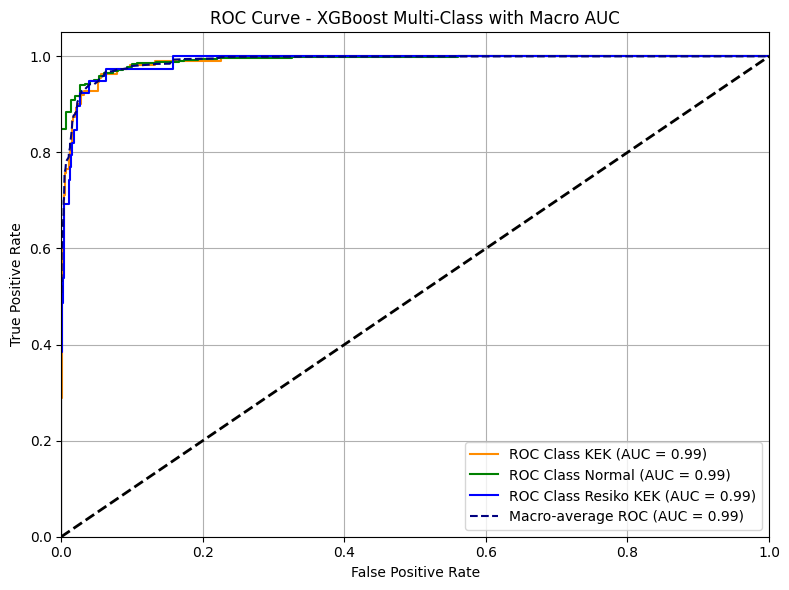

In [ ]:
# Binarisasi label untuk ROC Model terbaik (XGBoost)
# Binarisasi label
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Prediksi probabilitas dari pipeline
y_score = xgb_pipeline.predict_proba(X_test)

# Hitung FPR, TPR, dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Hitung Macro-average ROC Curve
# Gabungkan semua FPR
all_fpr = sorted(set([f for i in range(n_classes) for f in fpr[i]]))

# Interpolasi TPR dan rata-rata
import numpy as np
mean_tpr = np.zeros_like(all_fpr, dtype=np.float64)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

# Plot semua ROC Curve
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'ROC Class {list(target_mapping.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(all_fpr, mean_tpr, color='navy', linestyle='--',
         label=f'Macro-average ROC (AUC = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Multi-Class with Macro AUC')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# Simpan Model Terbaik

In [ ]:
# Simpan pipeline (preprocessing + SMOTE + model) ke file lokal
joblib.dump(xgb_pipeline, 'xgb_pipeline_model.joblib')
files.download('xgb_pipeline_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Ekstrak XGBoost model dari pipeline
xgb_model = xgb_pipeline.named_steps['classifier']

# Fit preprocessor dan ambil 1 sampel transformasi
preprocessor.fit(X_train)
sample = preprocessor.transform(X_train.head(1))
initial_type = [('float_input', FloatTensorType([None, sample.shape[1]]))]

# Konversi model XGBoost ke ONNX
onnx_model = onnxmltools.convert_xgboost(xgb_model, initial_types=initial_type)

# Simpan ke file lokal
with open("xgb_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

from google.colab import files
files.download("xgb_model.onnx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json
import numpy as np # Import numpy for checking scaler if used

# Correctly access the SimpleImputer and its statistics_ attribute
num_imputer = preprocessor.named_transformers_['num']

# Check if the imputer has the statistics_ attribute (it should if fit)
if hasattr(num_imputer, 'statistics_') and len(num_imputer.statistics_) > 0:
    scaler_params = {
        "mean": list(num_imputer.statistics_), # Use statistics_ for SimpleImputer mean
        # There is no 'scale' attribute for SimpleImputer,
        # if scaling was intended, add a scaler to the numerical pipeline
        "scale": None # Set scale to None or add scaler to pipeline
    }
else:
    # Handle case where imputer wasn't fit or has no statistics
    print("Warning: Numerical imputer has no statistics_ attribute. Ensure preprocessor is fit.")
    scaler_params = {
        "mean": None,
        "scale": None
    }


# Correctly access the Pipeline for categorical features and then the encoder within it
cat_pipeline = preprocessor.named_transformers_['cat']
# The encoder is the second step in the 'cat' pipeline (index 1)
encoder = cat_pipeline.named_steps['encoder']


# Access categories from the OneHotEncoder
if hasattr(encoder, 'categories_'):
    encoder_categories = encoder.categories_
    encoder_params = {
        "categories": [list(cat) for cat in encoder_categories]
    }
else:
     # Handle case where encoder wasn't fit or has no categories
    print("Warning: Categorical encoder has no categories_ attribute. Ensure preprocessor is fit.")
    encoder_params = {
        "categories": []
    }


# Gabungkan jadi satu dict
preprocessing_params = {
    "numerical_imputer": scaler_params, # Rename key to reflect it's imputer stats
    "categorical_encoder": encoder_params
}

# Simpan ke file JSON
with open("preprocessing_params.json", "w") as f:
    json.dump(preprocessing_params, f, indent=4) # Added indent for readability

print("Preprocessing parameters saved to preprocessing_params.json")

Preprocessing parameters saved to preprocessing_params.json


In [ ]:
pip freeze > requirements.txt